<br>

### 사전준비

<br>

In [28]:
!pip install opencv-python
!pip install cmake
!pip install dlib

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
print("🌫🛸")

🌫🛸


<br>

### 사진 읽어오기

<br>

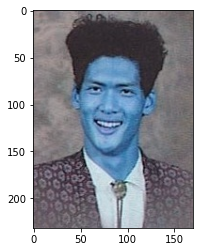

In [2]:
"""
OpenCV로 이미지 읽어오기 -> 이미지 리사이즈 -> (원본 카피)
"""

import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/face_sample_01.jpeg'
img_bgr = cv2.imread(my_image_path, -1)    # OpenCV로 이미지를 읽기
img_bgr = cv2.resize(img_bgr, (170,232))    # (170,232)의 크기로 Resize
img_show = img_bgr.copy()      # 출력용 원본 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

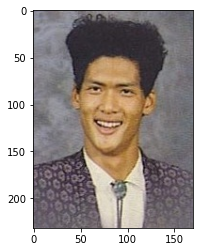

In [3]:
"""
RGB 이미지로 변경 (OpenCV는 default가 BGR)
"""

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # RGB 이미지로 변경
plt.imshow(img_rgb)
plt.show()

<br>

## 얼굴 검출 Face Detection

<br>

In [4]:
"""
dlib 패키지의 HOG(Histogram of Oriented Gradient) face detector 사용
( face decting을 위한 모델을 따로 학습하지 않고, 미리 학습된 모델을 라이브러리로 가져와서 사용 )
"""

import dlib

# detector 선언
detector_hog = dlib.get_frontal_face_detector()


# detector로 인식된 얼굴 범위의 rectangle 리턴
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # get_frontal_face_detector(image, num of img pyramid)
                                        # img pyramid : upsampling을 통해 이미지를 키움
print("dlib_rects :", dlib_rects)       # detector_hog()의 리턴 : rectangle 기준좌표

dlib_rects : rectangles[[(46, 63) (121, 138)]]


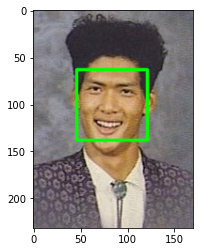

In [5]:
"""
OpenCV로 face detection 시각화
"""

for dlib_rect in dlib_rects:
    l = dlib_rect.left()                # cv2.rectangle에 필요한 기준좌표 네 개 재생성
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
                                        # OpenCV의 cv2.rectangle()로 사각형 생성

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

<br>

## 얼굴 랜드마크 Face Landmark Loclization

<br>

In [6]:
"""
object keypoint estimation 알고리즘을 사용
face dection rectangle 내부의 face landmark 찾기
dlib에서 제공하는 pretrained model 이용
"""

"""
공개된 weight file 다운로드하여 준비
$ wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
"""

import os

# pretrained model 호출
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)


# dection된 dlib_rect 범위 내부에서 face lanmark point 좌표검출
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
                                        # landmark_predictor(img, dlib.rectangle)
                                        # dlib.full_object_detection 리턴
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
                                        # dlib.full_object_detection.parts()로 개별 좌표 호출
                                        # parts()의 리턴을 (x,y) 형태로 매핑
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))
print(list_landmarks[0][0])
print(list_points[0])

68
(50, 82)
(50, 82)


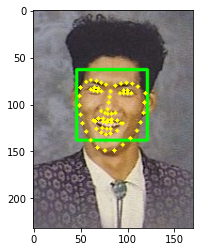

In [7]:
"""
OpenCV로 얼굴에 landmark 시각화
"""

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow
                                        # OpenCV의 cv2.circle()로 원 생성

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

<br>

## 스티커 적용하기

<br>

[(82, 86), (79, 105)]


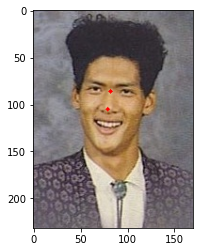

In [8]:
"""
스티커 이미지의 scale과 location의 기준점을 생성하기 위한 ctrol point 찾기
( dlib의 landmark 리스트 내에서 탐색 )
"""

# 기준점 표시용 이미지 cv2로 복사본 생성
img_ctrl = img_bgr.copy()
img_ctrl_point = cv2.cvtColor(img_ctrl, cv2.COLOR_BGR2RGB)

# dlib 에서 불러온 landmark 리스트에서 기준점 선정
list_cp_landmarks = [list_points[27], list_points[30]]   # 스티커 기준점 : 미간 점, 콧망울 점
print(list_cp_landmarks)

# OpenCV로 얼굴에 기준점 landmark 시각화
for idx, point in enumerate(list_cp_landmarks):
    cv2.circle(img_ctrl_point, point, 2, (255, 0, 0), -1) # red

plt.imshow(img_ctrl_point)
plt.show()

(79, 105)
(x,y) : (79,105)
(w,h) : (76,76)


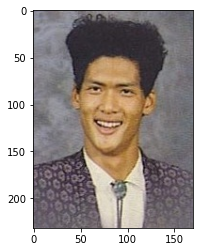

In [9]:
"""
스티커 이미지의 기준점 생성
"""

# 스티커 이미지의 기준점 (x,y)와 스티커 이미지의 크기 (w,h) 생성
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose coordinates (center index : 30)
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y)) # nose coodinates (?)
    print ('(w,h) : (%d,%d)'%(w,h)) # box width, height

# 원본사진 불러오기
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

In [10]:
# 스티커 이미지 불러오기 (리사이즈)

import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h)) # resize sticker width and height to box-size (w,h)
print (img_sticker.shape)

(76, 76, 3)


In [11]:
"""
스티커의 좌상단점 (refined_x, refined_y)
"""

refined_x = x - w // 2  # 좌
refined_y = y - h // 2   # 상
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (41,67)


In [13]:
"""
img_show 변수에 있는 원본이미지에서 스티커 이미지 영역 crop
crop된 자리에 스티커 이미지 데이터 삽입
"""

sticker_area = img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]]
img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)

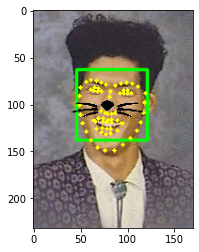

In [14]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

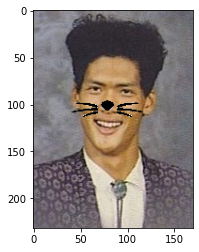

In [18]:
"""
원본 사진에 스티커 이미지만 붙여서 출력
위의 과정에서 img_show에는 cv2.rectangle과 cv2.circle이 들어가 있으므로 원본 img_bgr에 스티커 적용
"""

sticker_area = img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]]
img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)
    
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()